In [10]:
# Importación de bibliotecas estándar
import numpy as np
import pandas as pd

# Importación de bibliotecas para visualización
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.patches as mpatches

# Importando itertools para generar combinaciones de columnas
import itertools 

# Importando la función seasonal_decompose para la descomposición de series temporales
from statsmodels.tsa.seasonal import seasonal_decompose

# Importación de herramientas para modelos de machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn import metrics

# Importación de módulo personalizado
import payments_manager as pm

cr_cp = pm.df('cr_cp')
fe_cp = pm.df('fe_cp')
df_jo = pm.df('df_jo')
#df_jo = pm.sort("df_jo", ["id_cr"]).reset_index()
#df_jo = df_jo.drop(columns=['index'])
#df_jo = df_jo.drop(columns=['Mes_created_at'])
#df_jo_cp = df_jo.copy()
df_jo = pm.sort("df_jo", ["id_cr"]).reset_index()
df_jo = df_jo.drop(columns=['index'])
#df_jo.info()


In [11]:
# Datos de partida
pd.options.display.max_columns = None
pm.format_to_dates(df_jo, time_format='d') # 'min','s'
df = pm.df('df_hyper')
display(df)

,user_id,created_at_slot,created_at_dow,amount,n_fees,n_backs,n_recovery,n_inc_back,n_inc_fees,transfer_type,charge_moment,n_cr_fe_w,inflation,GBP_EUR,BTC_GBP,unemploy_rate,needs_m_check_recov
0,47,13,1,1.0,0,0,0,1,0,regular,NaN,0,1.3,1.16935,6347.577148,3.9,1
1,99001309,14,0,100.0,0,1,0,0,0,regular,NaN,1,1.3,1.18803,5630.115723,4.0,0
2,804,19,1,100.0,0,0,0,1,0,regular,NaN,0,1.3,1.18800,5543.707520,4.0,1
3,812,19,1,100.0,0,0,1,1,0,regular,NaN,0,1.3,1.18800,5543.707520,4.0,1
4,191,19,1,100.0,0,0,0,1,0,regular,NaN,0,1.3,1.18800,5543.707520,4.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32087,55916,23,6,50.0,2,2,0,1,0,instant,after,1,0.7,0.00000,10627.522461,5.3,0
32088,39339,23,6,100.0,3,3,0,0,0,instant,after,1,0.7,0.00000,10627.522461,5.3,0
32089,24505,23,6,50.0,2,2,3,4,4,instant,NaN,0,0.7,0.00000,10627.522461,5.3,1
32090,100781,23,6,60.0,1,1,0,0,0,instant,after,1,0.7,0.00000,10627.522461,5.3,0


In [12]:
X_log_L=df
y_log_L=df_jo['needs_m_check_recov']

In [13]:
X_log_L.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32092 entries, 0 to 32091
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              32092 non-null  int64  
 1   created_at_slot      32092 non-null  int32  
 2   created_at_dow       32092 non-null  int32  
 3   amount               32092 non-null  float64
 4   n_fees               32092 non-null  int64  
 5   n_backs              32092 non-null  int64  
 6   n_recovery           32092 non-null  int64  
 7   n_inc_back           32092 non-null  int64  
 8   n_inc_fees           32092 non-null  int64  
 9   transfer_type        32092 non-null  object 
 10  charge_moment        21055 non-null  object 
 11  n_cr_fe_w            32092 non-null  int64  
 12  inflation            32092 non-null  float64
 13  GBP_EUR              32092 non-null  float64
 14  BTC_GBP              32092 non-null  float64
 15  unemploy_rate        32092 non-null 

In [14]:
# Convertir las columnas de tipo timedelta64
#for col in X_log_L.select_dtypes(include=['timedelta64']).columns:
#    X_log_L[col] = X_log_L[col].apply(lambda x: x / pd.to_timedelta(1, unit='d') if pd.notnull(x) else None)

In [15]:
# Convertir las columnas de tipo datetime64
#for col in X_log_L.select_dtypes(include=['datetime64']).columns:
#    X_log_L[col] = X_log_L[col].apply(lambda x: x.timestamp() if pd.notnull(x) else None)

In [16]:
# One Hot econding para pasar a numéricas todas las categóricas
X_log_L = pd.get_dummies(X_log_L, columns=['transfer_type'], drop_first=True, dtype=int)

In [17]:
X_log_L = pd.get_dummies(X_log_L, columns= ['charge_moment'], drop_first=True, dtype=int)

In [18]:
# Rellenar NaN con 0
X_log_L = X_log_L.fillna(0)

In [19]:
X_log_L.describe()

,user_id,created_at_slot,created_at_dow,amount,n_fees,n_backs,n_recovery,n_inc_back,n_inc_fees,n_cr_fe_w,inflation,GBP_EUR,BTC_GBP,needs_m_check_recov,transfer_type_regular,charge_moment_before
count,3.209200e+04,32092.000000,32092.000000,32092.000000,32092.000000,32092.000000,32092.000000,32092.000000,32092.000000,32092.000000,32092.000000,32092.000000,32092.000000,32092.000000,32092.000000,32092.000000
mean,7.967657e+06,12.648137,2.748847,83.516733,0.978375,1.459491,0.711143,0.935498,1.092952,1.008787,0.632940,0.883637,8387.211870,0.523121,0.392746,0.135112
std,2.687968e+07,5.272898,1.828468,25.900555,1.126548,1.393508,1.701936,1.773505,2.181447,0.874855,0.287033,0.445121,1037.083991,0.499473,0.488369,0.341848
min,3.400000e+01,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,3954.907959,0.000000,0.000000,0.000000
25%,1.253700e+04,9.000000,1.000000,50.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.500000,1.090690,7574.018555,0.000000,0.000000,0.000000
50%,2.700500e+04,13.000000,3.000000,100.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.600000,1.102660,8435.253906,1.000000,0.000000,0.000000
75%,5.547150e+04,17.000000,4.000000,100.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,0.700000,1.108140,8948.752930,1.000000,1.000000,0.000000
max,9.903044e+07,23.000000,6.000000,200.000000,15.000000,11.000000,28.000000,21.000000,33.000000,13.000000,1.800000,1.204510,10645.804688,1.000000,1.000000,1.000000


In [20]:
# Visualización datos antes del escalador
display(X_log_L.head(10))

# Sacamos la variable objetivo que no se va a escalar
y = X_log_L['needs_m_check_recov'].copy()  #Segun moderated_at
X_log_L = X_log_L.drop(columns=['needs_m_check_recov'])

# Crear el escalador en este caso STANDARDSCALER
scaler = StandardScaler()

# Estandarizar todas las columnas
normalizado = scaler.fit_transform(X_log_L)

# Convertir de nuevo a DataFrame, preservando nombres de columnas e índices
X = pd.DataFrame(normalizado, columns=X_log_L.columns, index=df.index)

# Visualización datos después del escalador
display(X.head(10))

,user_id,created_at_slot,created_at_dow,amount,n_fees,n_backs,n_recovery,n_inc_back,n_inc_fees,n_cr_fe_w,inflation,GBP_EUR,BTC_GBP,unemploy_rate,needs_m_check_recov,transfer_type_regular,charge_moment_before
0,47,13,1,1.0,0,0,0,1,0,0,1.3,1.16935,6347.577148,3.9,1,1,0
1,99001309,14,0,100.0,0,1,0,0,0,1,1.3,1.18803,5630.115723,4.0,0,1,0
2,804,19,1,100.0,0,0,0,1,0,0,1.3,1.18800,5543.707520,4.0,1,1,0
3,812,19,1,100.0,0,0,1,1,0,0,1.3,1.18800,5543.707520,4.0,1,1,0
4,191,19,1,100.0,0,0,0,1,0,0,1.3,1.18800,5543.707520,4.0,1,1,0
5,430,19,1,100.0,0,1,1,0,1,1,1.3,1.18800,5543.707520,4.0,1,1,0
6,761,19,1,99.0,0,0,0,1,0,0,1.3,1.18800,5543.707520,4.0,1,1,0
7,735,19,1,100.0,0,1,0,0,0,1,1.3,1.18800,5543.707520,4.0,0,1,0
8,406,19,1,100.0,0,0,1,1,0,0,1.3,1.18800,5543.707520,4.0,1,1,0
9,140,19,1,100.0,0,1,0,0,0,1,1.3,1.18800,5543.707520,4.0,0,1,0


,user_id,created_at_slot,created_at_dow,amount,n_fees,n_backs,n_recovery,n_inc_back,n_inc_fees,n_cr_fe_w,inflation,GBP_EUR,BTC_GBP,unemploy_rate,transfer_type_regular,charge_moment_before
0,-0.296422,0.066732,-0.956470,-3.185956,-0.868485,-1.047367,-0.417850,0.036370,-0.501029,-1.153109,2.324022,0.641888,-1.966732,-2.926786,1.243453,-0.395245
1,3.386761,0.256384,-1.503384,0.636416,-0.868485,-0.329742,-0.417850,-0.527494,-0.501029,-0.010044,2.324022,0.683855,-2.658549,-2.640847,1.243453,-0.395245
2,-0.296394,1.204643,-0.956470,0.636416,-0.868485,-1.047367,-0.417850,0.036370,-0.501029,-1.153109,2.324022,0.683787,-2.741869,-2.640847,1.243453,-0.395245
3,-0.296394,1.204643,-0.956470,0.636416,-0.868485,-1.047367,0.169725,0.036370,-0.501029,-1.153109,2.324022,0.683787,-2.741869,-2.640847,1.243453,-0.395245
4,-0.296417,1.204643,-0.956470,0.636416,-0.868485,-1.047367,-0.417850,0.036370,-0.501029,-1.153109,2.324022,0.683787,-2.741869,-2.640847,1.243453,-0.395245
5,-0.296408,1.204643,-0.956470,0.636416,-0.868485,-0.329742,0.169725,-0.527494,-0.042611,-0.010044,2.324022,0.683787,-2.741869,-2.640847,1.243453,-0.395245
6,-0.296396,1.204643,-0.956470,0.597806,-0.868485,-1.047367,-0.417850,0.036370,-0.501029,-1.153109,2.324022,0.683787,-2.741869,-2.640847,1.243453,-0.395245
7,-0.296397,1.204643,-0.956470,0.636416,-0.868485,-0.329742,-0.417850,-0.527494,-0.501029,-0.010044,2.324022,0.683787,-2.741869,-2.640847,1.243453,-0.395245
8,-0.296409,1.204643,-0.956470,0.636416,-0.868485,-1.047367,0.169725,0.036370,-0.501029,-1.153109,2.324022,0.683787,-2.741869,-2.640847,1.243453,-0.395245
9,-0.296419,1.204643,-0.956470,0.636416,-0.868485,-0.329742,-0.417850,-0.527494,-0.501029,-0.010044,2.324022,0.683787,-2.741869,-2.640847,1.243453,-0.395245


Coeficientes del modelo de regresión logística (ordenados por magnitud):
n_recovery: 3.12843555
n_inc_fees: 2.55107623
n_fees: -1.25735155
n_backs: -1.22444505
n_cr_fe_w: -0.92805661
n_inc_back: 0.90836178
charge_moment_before: 0.39423248
BTC_GBP: -0.38599606
transfer_type_regular: -0.37854794
inflation: -0.26074532
amount: 0.25793091
unemploy_rate: 0.20556709
user_id: 0.17138750
created_at_dow: -0.01612059
created_at_slot: -0.01112444
GBP_EUR: 0.00413208

Multiplicadores de odds (elevando exp a los coeficientes):
n_recovery: 22.83822222
n_inc_fees: 12.82089457
n_fees: 0.28440627
n_backs: 0.29392077
n_cr_fe_w: 0.39532123
n_inc_back: 2.48025599
charge_moment_before: 1.48324534
BTC_GBP: 0.67977321
transfer_type_regular: 0.68485514
inflation: 0.77047712
amount: 1.29424940
unemploy_rate: 1.22822138
user_id: 1.18695061
created_at_dow: 0.98400865
created_at_slot: 0.98893721
GBP_EUR: 1.00414063


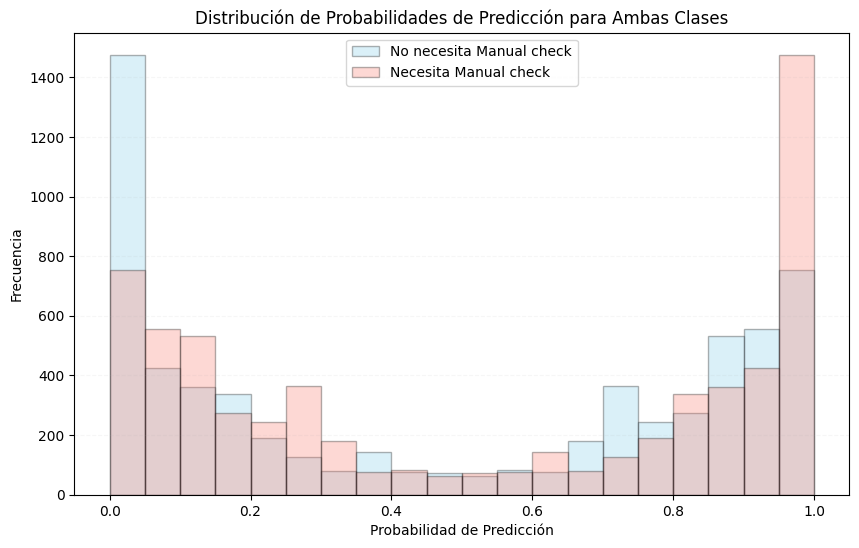

Accuracy: 0.9272472347717713
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.94      0.92      3005
           1       0.95      0.91      0.93      3414

    accuracy                           0.93      6419
   macro avg       0.93      0.93      0.93      6419
weighted avg       0.93      0.93      0.93      6419



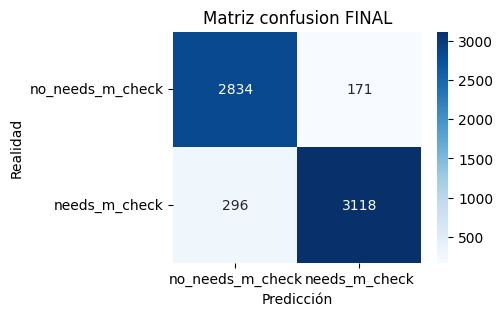

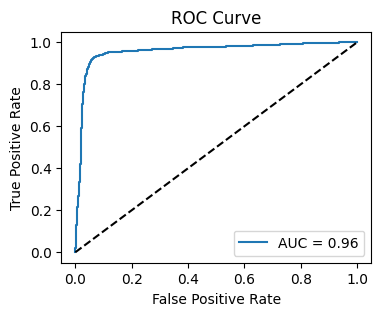

In [ ]:
# Pasamos MODELO DE REGRESIÓN LOGISTICA BASE, con todas las caracteristicas SIN BALANCEO DE CARGAS.

# Obtener los nombres de las características
feature_names = X.columns

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

# Crea el clasificador de regresión logística. El 'liblinear' usa metodo de optimización de minimos cuadrados generalizados (L2) y soporta la regularización L1 y L2
clf = LogisticRegression(solver="liblinear")

# Entrena el clasificador
clf.fit(X_train, y_train)

# Realiza predicciones sobre el conjunto de prueba
predicciones = clf.predict(X_test)

# Genera las probabilidades de predicción
predicciones_probabilidades = clf.predict_proba(X_test)

# Muestra las primeras 10 probabilidades de predicción
#predicciones_probabilidades[:10]

# Obtén los coeficientes y asigna los nombres de las características
coeficientes = clf.coef_[0]  # clf.coef_ es un array bidimensional, tomamos la primera fila
feature_coef = list(zip(feature_names, coeficientes))

# Ordena las características por el valor absoluto del coeficiente en orden descendente
feature_coef_sorted = sorted(feature_coef, key=lambda x: abs(x[1]), reverse=True)

# Imprime cada variable junto con su coeficiente ordenado
print("Coeficientes del modelo de regresión logística (ordenados por magnitud):")
for feature, coef in feature_coef_sorted:
    print(f"{feature}: {coef:.8f}")
    
# Convertir coeficientes a multiplicadores de odds
feature_odds = [(feature, np.exp(coef)) for feature, coef in feature_coef_sorted]

# Imprimir los resultados
print("\nMultiplicadores de odds (elevando exp a los coeficientes):")
for feature, odds in feature_odds:
    print(f"{feature}: {odds:.8f}")
    
# Crea un histograma de las probabilidades de predicción para ambas clases
plt.figure(figsize=(10, 6)) 

# # Histograma para la clase negativa (no need manual check)
plt.hist(predicciones_probabilidades[:, 0], bins=20, color="skyblue", edgecolor="black", alpha=0.3, label="No necesita Manual check")
# Histograma para la clase positiva ( need manual check)
plt.hist(predicciones_probabilidades[:, 1], bins=20, color="salmon", edgecolor="black", alpha=0.3, label="Necesita Manual check")
# Título y etiquetas de los ejes
plt.title("Distribución de Probabilidades de Predicción para Ambas Clases")
plt.xlabel("Probabilidad de Predicción")
plt.ylabel("Frecuencia")
plt.legend(loc="upper center") 
# Muestra la leyenda en el gráfico
plt.grid(axis="y", linestyle="--", alpha=0.1)
plt.show()

# Evaluate model performance
print("Accuracy:", clf.score(X_test, y_test))  # Accuracy score
print("Classification Report:\n", classification_report(y_test, predicciones))  # Classification report

# Genera la matriz de confusión
matriz_confusion = confusion_matrix(y_test, predicciones)
columnas = ['no_needs_m_check', 'needs_m_check'] # 0 para No necesita manual check y 1 para Sí necesita manual check

# Visualiza la matriz de confusión utilizando un mapa de calor

plt.figure(figsize=(4, 3))
sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues', xticklabels=columnas, yticklabels=columnas)
plt.title('Matriz confusion FINAL')
plt.xlabel("Predicción")
plt.ylabel("Realidad")
plt.show()

plt.figure(figsize=(4, 3))
fpr, tpr, thresholds = roc_curve(y_test, predicciones_probabilidades[:, 1])
plt.plot(fpr, tpr, label=f"AUC = {auc(fpr, tpr):.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [44]:
# Probar modificando el umbral. Cambio a 0.4 (por ejemplo)
umbral = 0.4
predicciones_modificadas = (predicciones_probabilidades[:, 1] >= umbral).astype(int)

Accuracy: 0.9272472347717713
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.92      0.92      3005
           1       0.93      0.94      0.93      3414

    accuracy                           0.93      6419
   macro avg       0.93      0.93      0.93      6419
weighted avg       0.93      0.93      0.93      6419



Text(20.581597222222214, 0.5, 'Realidad')

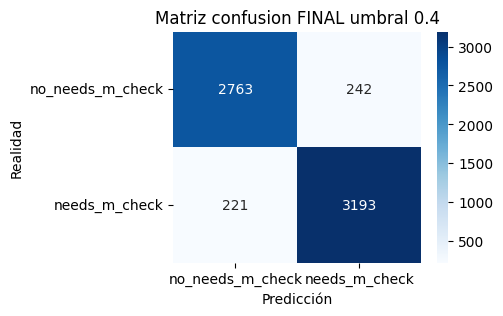

In [47]:
# Evaluate model performance con umbral modificado
print("Accuracy:", clf.score(X_test, y_test))  # Accuracy score
print("Classification Report:\n", classification_report(y_test, predicciones_modificadas))  # Classification report

# Genera la matriz de confusión
matriz_confusion2 = confusion_matrix(y_test, predicciones_modificadas)
columnas = ['no_needs_m_check', 'needs_m_check'] # 0 para No necesita manual check y 1 para Sí necesita manual check

# Visualiza la matriz de confusión utilizando un mapa de calor
plt.figure(figsize=(4, 3))
sns.heatmap(matriz_confusion2, annot=True, fmt='d', cmap='Blues', xticklabels=columnas, yticklabels=columnas)
plt.title('Matriz confusion FINAL umbral 0.4')
plt.xlabel("Predicción")
plt.ylabel("Realidad")

In [48]:
# Cálculo porcentaje de Falsos Negativos y de Falsos Positivos

# Extraer los valores de la matriz de confusión
TN, FP, FN, TP = matriz_confusion.ravel()

# Calcular el porcentaje de Falsos Negativos
porcentaje_FN = (FN / (FN + TP)) * 100

# Calcular el porcentaje de Falsos Positivos
porcentaje_FP = (FP / (FP + TN)) * 100

# Imprimir los resultados
print(f"Porcentaje de Falsos Negativos: {porcentaje_FN:.2f}%")
print(f"Porcentaje de Falsos Positivos: {porcentaje_FP:.2f}%")

Porcentaje de Falsos Negativos: 8.67%
Porcentaje de Falsos Positivos: 5.69%


In [30]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

# Asegurar reproducibilidad
np.random.seed(42)

# Convertir a matrices numpy
X_np = X.to_numpy()
y_np = y.to_numpy()

# Configurar la validación cruzada de 10 pliegues
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Hiperparámetros a evaluar
C_range = [0.001,0.1, 1, 2.78,10,166.81]
#C_range = [.1, 1, 10,100,10000]  # .0001 .001, .01, ...  , 10000 Valores de C (regularización)
penalty_types = ['l2', 'l1']  # Tipos de penalización
scalers = {'StandardScaler': StandardScaler()}  # Escaladores
#solver_types = {'l1': 'saga', 'l2': 'lbfgs'}  # Solvers adecuados
solver_types = {'l2': 'liblinear', 'l1': 'liblinear', 'l2': 'lbfgs'}  # Solvers adecuados

# Inicializar estructura para almacenar resultados
param_combinations = [(C, penalty, scaler_name) for C in C_range for penalty in penalty_types for scaler_name in scalers.keys()]

results = np.zeros((kf.get_n_splits(), len(param_combinations)))

# Iterar sobre los pliegues
for fold, (train_idx, val_idx) in enumerate(kf.split(X_np)):
    X_train, X_val = X_np[train_idx], X_np[val_idx]
    y_train, y_val = y_np[train_idx], y_np[val_idx]

    #if penalty =='l2' & solver_types =='liblinear':
    #    C =1

    # Iterar sobre las combinaciones de hiperparámetros
    for i, (C, penalty, scaler_name) in enumerate(param_combinations):
        # Escalar los datos
        scaler = scalers[scaler_name]
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)

        clf = LogisticRegression(
            C=C, penalty=penalty, solver=solver_types[penalty], random_state=42, max_iter=1000
        )

        # Entrenar y evaluar
        clf.fit(X_train_scaled, y_train)
        y_pred = clf.predict(X_val_scaled)
        results[fold, i] =  accuracy_score(y_val, y_pred)
        #results[fold, i] = precision_score(y_val, y_pred) #accuracy_score(y_val, y_pred)
        #results[fold, i] = roc_auc_score(y_val, y_pred)

for r in enumerate(results):
    results[fold, i] =  accuracy_score(y_val, y_pred)


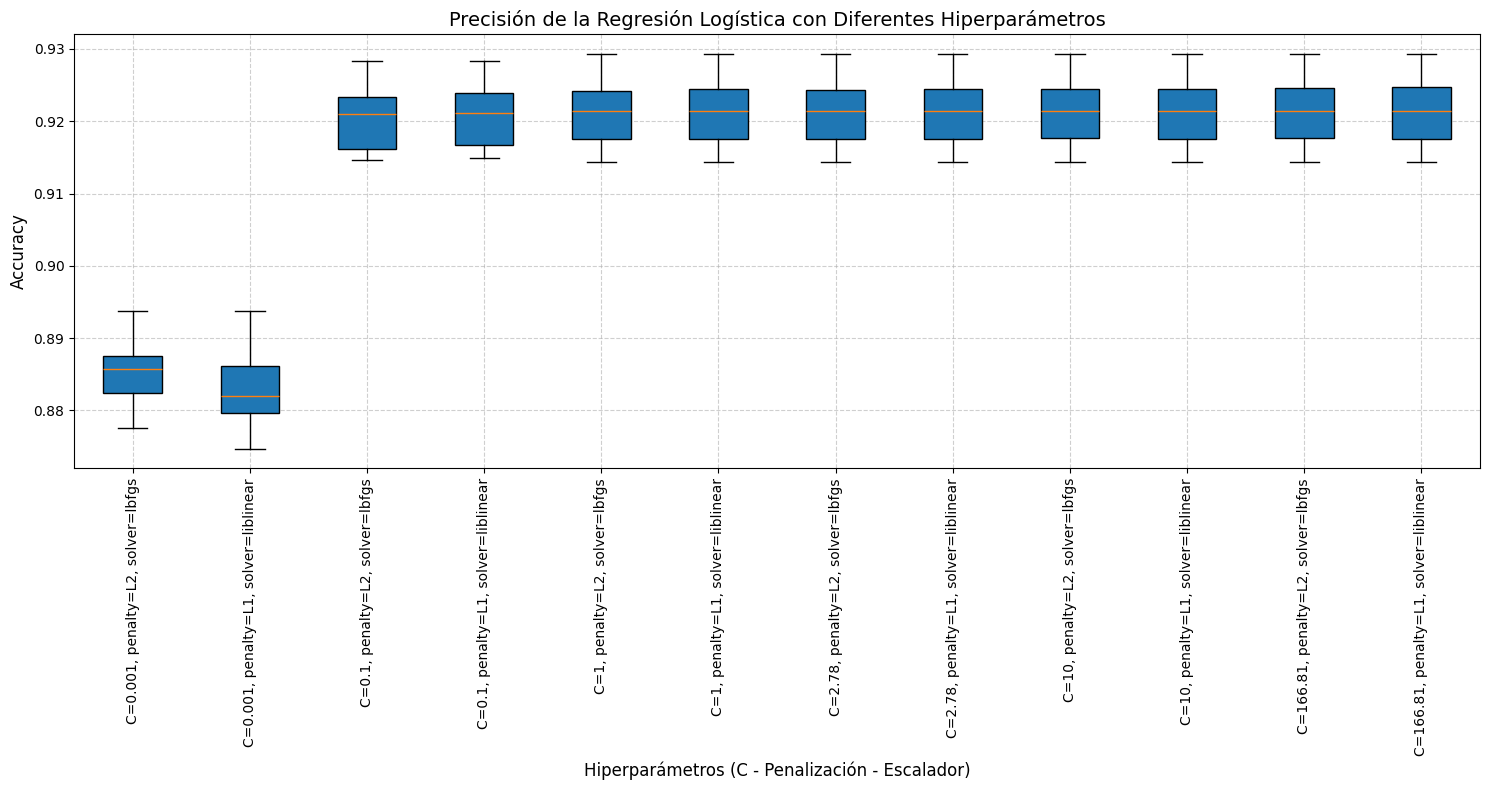

In [41]:
# Graficar los resultados
plt.figure(figsize=(15, 8))

# Configurar etiquetas para los hiperparámetros
#tick_labels = [f'C={C}, {penalty.upper()}, {solver_types[penalty]}, {scaler}' for C, penalty, scaler in param_combinations]
tick_labels = [
    f'C={C}, penalty={penalty.upper()}, solver={solver_types.get(penalty, "Unknown")}'
    for C, penalty, scaler in param_combinations
]
# Crear el boxplot
plt.boxplot(results, vert=True, patch_artist=True, meanline=True)
plt.xticks(ticks=np.arange(1, len(tick_labels) + 1), labels=tick_labels, rotation=90, fontsize=10)
plt.xlabel('Hiperparámetros (C - Penalización - Escalador)', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Precisión de la Regresión Logística con Diferentes Hiperparámetros', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


Total de muestras: 500
500


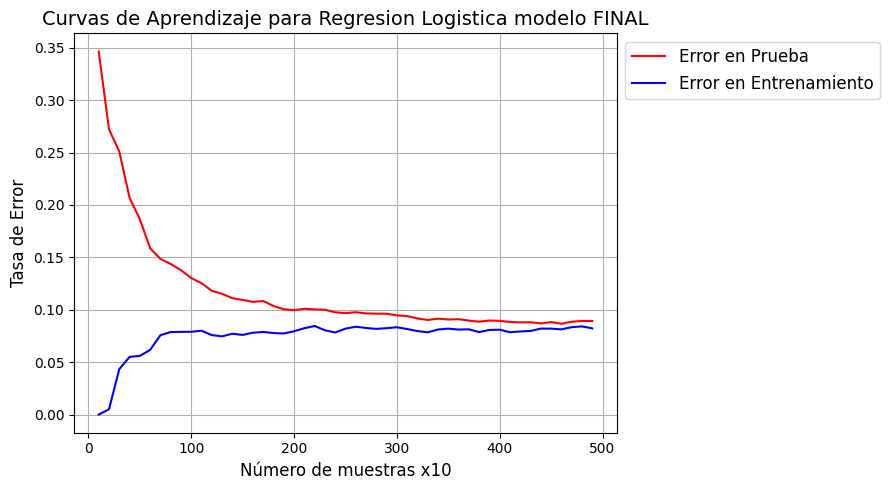

In [52]:
# Graficar curvas de error. 

np.random.seed(42)
# Parámetros
MAXN = 500 # len(X)  # Total de muestras disponibles
steps = 10  # Tamaño de incremento del conjunto de entrenamiento
iterations = 10  # Número de iteraciones para suavizar los resultados
print(f"Total de muestras: {MAXN}")

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2) #, random_state=42)
#display(X_test)
#display(y_test)

print(f"{(MAXN // steps) * steps + 0 }")

# Calcular el número de columnas
cols = list(range(steps, (MAXN // steps) * steps, steps))

# Inicializamos los DataFrames para almacenar los errores
test_errors = pd.DataFrame(np.zeros((iterations, len(cols))), columns=cols)
train_errors = pd.DataFrame(np.zeros((iterations, len(cols))), columns=cols)

# Generamos los errores promedios por iteración
for iteration in range(iterations):
    # Mezclamos los datos
    data = pd.concat([X, y], axis=1).sample(frac=1).reset_index(drop=True)
    X_shuffled = data[X.columns]
    y_shuffled = data[y.name]
    
    for N in range(steps, MAXN, steps):
        j = (N // steps) - 1  # Índice para almacenar resultados
        
        # Tomar un subconjunto de datos para entrenamiento
        X_subset = X_shuffled.iloc[:N, :]
        y_subset = y_shuffled.iloc[:N]
        
        # Crear y entrenar el modelo de regresión logística
        clf = LogisticRegression(solver="liblinear", max_iter=1000)
        clf.fit(X_subset, y_subset)
        
        # Evaluar el modelo en el conjunto de prueba y calcular la tasa de error.
        test_errors.iloc[iteration, j] = 1 - metrics.accuracy_score(clf.predict(X_test), y_test)
        # Evaluar el modelo en el conjunto de entrenamiento y calcular la tasa de error.
        train_errors.iloc[iteration, j] = 1 - metrics.accuracy_score(clf.predict(X_subset), y_subset)

# Promediar las tasas de error a lo largo de las iteraciones para obtener una curva de aprendizaje más estable.
mean_test_error = test_errors.mean(axis=0)
mean_train_error = train_errors.mean(axis=0)

# Graficar las curvas de aprendizaje: tasa de error en prueba y entrenamiento.
plt.figure(figsize=(9, 5))
plt.plot(mean_test_error, 'r', label='Error en Prueba') # Error en el conjunto de prueba.
plt.plot(mean_train_error, 'b', label='Error en Entrenamiento') # Error en el conjunto de entrenamiento.

# Configurar etiquetas, título y leyenda.
plt.xlabel('Número de muestras x10', fontsize=12)
plt.ylabel('Tasa de Error', fontsize=12)
plt.title('Curvas de Aprendizaje para Regresion Logistica modelo FINAL', fontsize=14)
plt.legend(loc='upper left', fontsize=12, bbox_to_anchor=(1, 1))

# Mostrar la gráfica con las curvas de error.
plt.grid(True)
plt.tight_layout() # Ajustar la distribución para evitar que las etiquetas se corten.
plt.show()